# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="../images/bcamp.png" align="center">

## 13  PyTorch Logistic Regression 

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="../images/pt.jpg" width="35%" align="center">


# PyTorch Imports


In [57]:
# !pip install pycuda
%reset -f
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2

tensorflow:1.2.1
__Python VERSION: 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.1.12+4eb448a
__CUDA VERSION
__CUDNN VERSION: 5110
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


#  Load a CSV file for Binary classification

In [58]:
% reset -f

import torch
from torch.autograd import Variable
import numpy as np
import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import logging
handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)

%matplotlib inline

F_NAME_TRAIN= 'data-03-diabetes.csv'

X_df_train= pd.read_csv(F_NAME_TRAIN,header=None)
X_df_train_SINGLE=X_df_train.copy(deep=True)
answers_1_SINGLE = list (X_df_train_SINGLE[X_df_train_SINGLE.columns[-1]].values)
answers_1_SINGLE= map(int, answers_1_SINGLE)
X_df_train_SINGLE = X_df_train_SINGLE.drop(X_df_train_SINGLE.columns[-1], axis=1)
X_df_train_SINGLE=X_df_train_SINGLE.apply(lambda x: pandas.to_numeric(x, errors='ignore'))  

print(X_df_train_SINGLE.shape)

X_df_train_SINGLE.head(5)

(759, 8)


,0,1,2,3,4,5,6,7
0,-0.294118,0.487437,0.180328,-0.292929,0.000000,0.001490,-0.531170,-0.033333
1,-0.882353,-0.145729,0.081967,-0.414141,0.000000,-0.207153,-0.766866,-0.666667
2,-0.058824,0.839196,0.049180,0.000000,0.000000,-0.305514,-0.492741,-0.633333
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,0.000000
4,0.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000


#  Create PyTorch GPU tensors

- Note how we transfrom the np arrays

In [59]:
# fix seed
seed=17*19
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
        
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

# sk learn
trainX, testX, trainY, testY = train_test_split(X_df_train_SINGLE, answers_1_SINGLE, test_size=.10, random_state=999)  

x_data_np = np.array(trainX.values, dtype=np.float32)
y_data_np = np.array(trainY, dtype=np.float32)
y_data_np=y_data_np.reshape((y_data_np.shape[0],1)) # Must be reshaped for PyTorch!


print(x_data_np.shape, y_data_np.shape)
print(type(x_data_np), type(y_data_np))

if use_cuda:
    lgr.info ("Using the GPU")    
    X = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch
    Y = Variable(torch.from_numpy(y_data_np).cuda())
else:
    lgr.info ("Using the CPU")
    X = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
    Y = Variable(torch.from_numpy(y_data_np))

    
print(type(X.data), type(Y.data)) # should be 'torch.cuda.FloatTensor'

INFO:__main__:Using the GPU


(683, 8) (683, 1)
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<class 'torch.cuda.FloatTensor'> <class 'torch.cuda.FloatTensor'>


#  Define the NN model

- First a simple two leyer network and then a more involved version

In [60]:
hiddenLayer1Size=30
hiddenLayer2Size=15
# # Hypothesis using sigmoid
linear1=torch.nn.Linear(x_data_np.shape[1], hiddenLayer1Size, bias=True) # size mismatch, m1: [5373 x 344], m2: [8 x 1] at /pytorch/torch/lib/TH/generic/THTensorMath.c:1293
linear2=torch.nn.Linear(hiddenLayer1Size, hiddenLayer2Size)    
linear3=torch.nn.Linear(hiddenLayer2Size, 1)    
sigmoid = torch.nn.Sigmoid()
tanh=torch.nn.Tanh()
model = torch.nn.Sequential(linear1,tanh, linear2, tanh, linear3, sigmoid)


# # Hypothesis using sigmoid
# linear1=torch.nn.Linear(x_data_np.shape[1], 1, bias=True) 
# sigmoid = torch.nn.Sigmoid()
# model = torch.nn.Sequential(linear1,sigmoid)

if use_cuda:
    lgr.info ("Using the GPU")
    model = model.cuda() # On GPU
else:
    lgr.info ("Using the CPU")   

lgr.info('Model {}'.format(model))

INFO:__main__:Using the GPU
INFO:__main__:Model Sequential (
  (0): Linear (8 -> 30)
  (1): Tanh ()
  (2): Linear (30 -> 15)
  (3): Tanh ()
  (4): Linear (15 -> 1)
  (5): Sigmoid ()
)


In [61]:
# see https://github.com/facebookresearch/SentEval/blob/master/senteval/tools/classifier.py
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(model.parameters())
lgr.info('Optimizer {}'.format(optimizer))

INFO:__main__:Optimizer <torch.optim.sgd.SGD object at 0x7fb0acc6d6d0>


# Start training in Batches

0 [ 0.68530244]
Accuracy:0.664714515209
ROC AUC:0.526725521669
2000 [ 0.45562223]
Accuracy:0.765739381313
ROC AUC:0.727386460202
4000 [ 0.42640173]
Accuracy:0.783308923244
ROC AUC:0.748687564914
6000 [ 0.41219527]
Accuracy:0.793557822704
ROC AUC:0.761438957606
8000 [ 0.39686078]
Accuracy:0.80234259367
ROC AUC:0.771112265131
10000 [ 0.37531993]
Accuracy:0.819912135601
ROC AUC:0.805117552639
12000 [ 0.34803271]
Accuracy:0.838945806026
ROC AUC:0.826565008026
14000 [ 0.32000631]
Accuracy:0.856515347958
ROC AUC:0.845911623076
16000 [ 0.29063779]
Accuracy:0.872620761395
ROC AUC:0.86120290813
18000 [ 0.24829108]
Accuracy:0.896046876907
ROC AUC:0.890907374186
GPU: 17.811 seconds


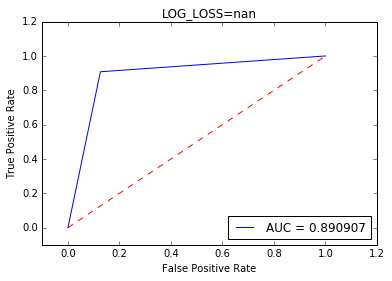

In [62]:
import time
start_time = time.time()    
epochs=20000

for step in range(epochs):
    optimizer.zero_grad()
    hypothesis = model(X)    
    # cost/loss function
    cost = -(Y * torch.log(hypothesis) + (1 - Y)
             * torch.log(1 - hypothesis)).mean()
    cost.backward()
    optimizer.step()

    if step % 2000 == 0:
        print(step, cost.data.cpu().numpy())
        # RuntimeError: can't convert CUDA tensor to numpy (it doesn't support GPU arrays). 
        # Use .cpu() to move the tensor to host memory first.
        predicted = (model(X).data > 0.5).float()
        predictions=predicted.cpu().numpy()
        accuracy = (predicted == Y.data).float().mean()
        print('Accuracy:' + str(accuracy))
        R_SCORE=roc_auc_score(Y.data.cpu().numpy(),predictions )        
        print ('ROC AUC:' + str(R_SCORE))

end_time = time.time()
print ('{} {:6.3f} seconds'.format('GPU:', end_time-start_time))


false_positive_rate, true_positive_rate, thresholds = roc_curve(trainY, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('LOG_LOSS=' + str(log_loss(trainY, predictions)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
model.eval()

Sequential (
  (0): Linear (8 -> 30)
  (1): Tanh ()
  (2): Linear (30 -> 15)
  (3): Tanh ()
  (4): Linear (15 -> 1)
  (5): Sigmoid ()
)

In [ ]:
def score(self, devX, devy):
        self.model.eval()
        correct = 0
        if not isinstance(devX, torch.cuda.FloatTensor) or self.cudaEfficient:
            devX = torch.FloatTensor(devX).cuda()
            devy = torch.LongTensor(devy).cuda()
        for i in range(0, len(devX), self.batch_size):
            Xbatch = Variable(devX[i:i + self.batch_size], volatile=True)
            ybatch = Variable(devy[i:i + self.batch_size], volatile=True)
            if self.cudaEfficient:
                Xbatch = Xbatch.cuda()
                ybatch = ybatch.cuda()
            output = self.model(Xbatch)
            pred = output.data.max(1)[1]
            correct += pred.long().eq(ybatch.data.long()).sum()
        accuracy = 1.0*correct / len(devX)
        return accuracy